loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
INFO __main__ 18:53:53 | THIS IS PRINTING HOW THE IMAGE AND LABELS LOOK DURING EVALUAITON
INFO __main__ 18:53:53 | Starting evaluation...
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
imgs shape: torch.Size([3, 384, 384])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


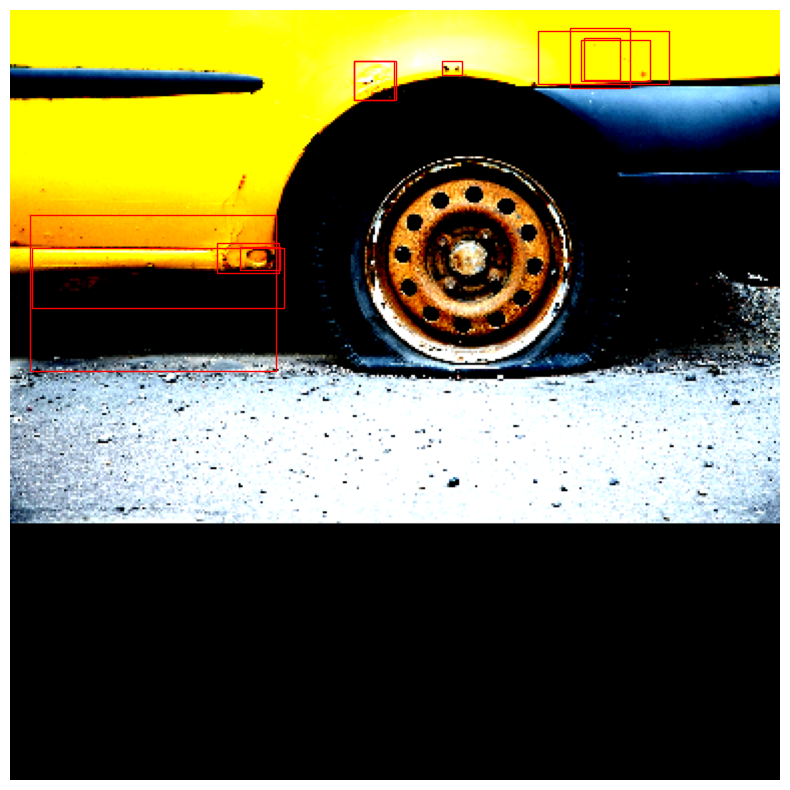

/home/bachelor/ml-carbucks/.venv/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric MeanAveragePrecision was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


INFO __main__ 18:53:54 | THIS IS PRINTING HOW THE IMAGE AND LABELS LOOK DURING PREDICTION


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


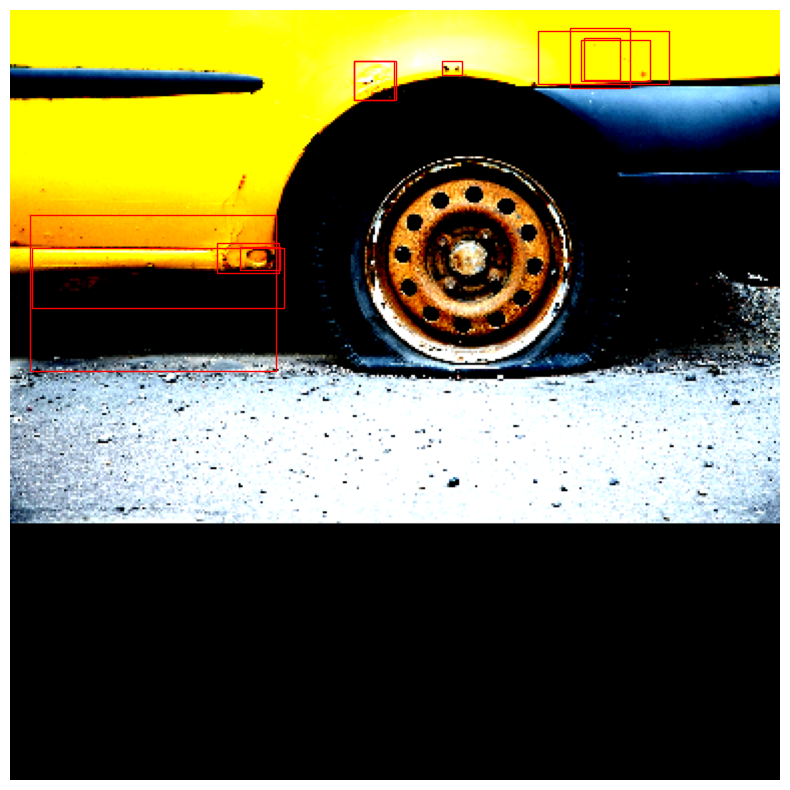

INFO __main__ 18:53:54 | THIS IS PRINTING HOW THE IMAGE AND LABELS LOOK POSTPROCESSED


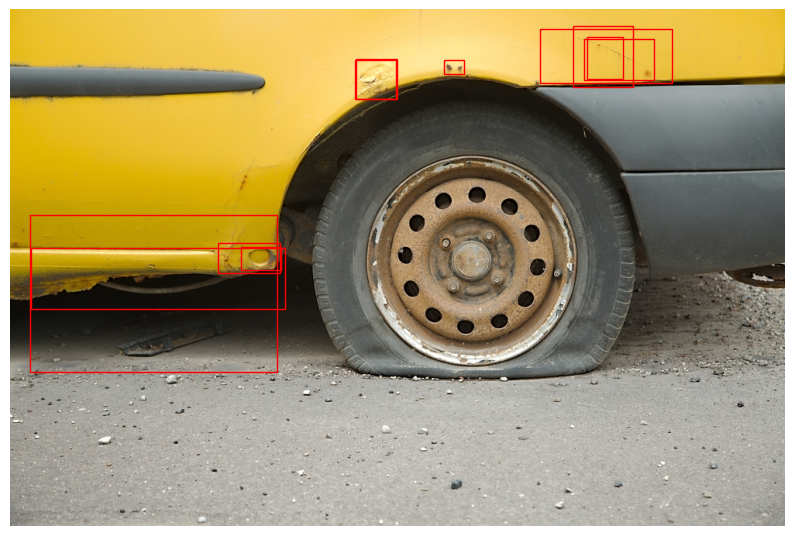

In [16]:

from dataclasses import dataclass
from pathlib import Path
from typing import Dict, List, Literal, Optional, Tuple

import torch
from tqdm import tqdm
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import DataLoader
from torchvision.models.detection.faster_rcnn import (
    FastRCNNPredictor,
    fasterrcnn_resnet50_fpn,
    FasterRCNN_ResNet50_FPN_Weights,
)
from torchmetrics.detection.mean_ap import MeanAveragePrecision

from ml_carbucks.adapters.BaseDetectionAdapter import (
    ADAPTER_PREDICTION,
    BaseDetectionAdapter,
)
from ml_carbucks.utils.logger import setup_logger
from ml_carbucks.utils.postprocessing import postprocess_prediction
from ml_carbucks.utils.preprocessing import create_clean_loader, create_transforms
from ml_carbucks.utils.result_saver import ResultSaver
from ml_carbucks.utils.inference import plot_img_pred as ppp
from ml_carbucks import DATA_DIR
import numpy as np

logger = setup_logger(__name__)


@dataclass
class FasterRcnnAdapter(BaseDetectionAdapter):

    weights: str | Path = "DEFAULT"

    lr_backbone: float = 5e-5
    lr_head: float = 5e-4
    weight_decay_backbone: float = 1e-5
    weight_decay_head: float = 1e-4
    optimizer: Literal["Adam", "AdamW", "RAdam", "SGD"] = "Adam"
    clip_gradients: Optional[float] = None
    training_augmentations: bool = True
    momentum: float = 0.9  # Used for SGD and RMSprop

    def save(self, dir: Path | str, prefix: str = "", suffix: str = "") -> Path:
        save_path = Path(dir) / f"{prefix}model{suffix}.pth"
        save_path.parent.mkdir(parents=True, exist_ok=True)
        torch.save(self.model.state_dict(), save_path)
        return save_path

    def _preprocess_images(
        self, images: List[np.ndarray]
    ) -> Tuple[List[torch.Tensor], List[float]]:
        transform = create_transforms(is_training=False, img_size=self.img_size)

        preprocessed_samples = [
            transform(image=img, bboxes=[], labels=[]) for img in images
        ]
        preprocessed_images = [sample["image"] for sample in preprocessed_samples]

        scales = [self.img_size / max(img.shape[0], img.shape[1]) for img in images]

        return preprocessed_images, scales

    def predict(self, images: List[np.ndarray]) -> List[ADAPTER_PREDICTION]:
        self.model.eval()

        preprocessed_images, scales = self._preprocess_images(images)

        images_fasterrcnn = [img.to(self.device) for img in preprocessed_images]

        
        with torch.no_grad():
            outputs = self.model(images_fasterrcnn)
        
        iii = 1

        for j in range(iii):
            ppp(
                images_fasterrcnn[j],
                outputs[j]["boxes"],
                coords="xyxy"
            )

        conf_threshold = -1
        iou_threshold = -1
        max_detections = -1

        processed_predictions: List[ADAPTER_PREDICTION] = []
        for i, output in enumerate(outputs):
            boxes = output["boxes"] / scales[i]
            scores = output["scores"]
            labels = output["labels"]

            if conf_threshold >= 0:
                prediction = postprocess_prediction(
                    boxes,
                    scores,
                    labels,
                    conf_threshold,
                    iou_threshold,
                    max_detections,
                )
            else:
                prediction: ADAPTER_PREDICTION = {
                    "boxes": boxes.cpu(),
                    "scores": scores.cpu(),
                    "labels": labels.cpu().long(),
                }

            processed_predictions.append(prediction)

        return processed_predictions

    def setup(self) -> "FasterRcnnAdapter":
        logger.debug("Creating Faster R-CNN model...")

        img_size = self.img_size

        weights = self.weights

        if weights == "DEFAULT":
            self.model = fasterrcnn_resnet50_fpn(
                weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT,
                min_size=img_size,
                max_size=img_size,
            )
            in_features = self.model.roi_heads.box_predictor.cls_score.in_features  # type: ignore
            self.model.roi_heads.box_predictor = FastRCNNPredictor(
                in_features, len(self.classes) + 1  # +1 for background
            )
        elif weights is not None and Path(weights).is_file():
            self.model = fasterrcnn_resnet50_fpn(
                num_classes=len(self.classes) + 1
            )  # +1 for background
            checkpoint = torch.load(weights, map_location=self.device)  # type: ignore
            self.model.load_state_dict(checkpoint)
        else:
            raise ValueError(
                "Weights must be 'DEFAULT' or a valid path to a checkpoint."
            )

        self.model.to(self.device)

        return self

    def _create_optimizer(self):
        lr1 = self.lr_backbone
        lr2 = self.lr_head
        weight_decay1 = self.weight_decay_backbone
        weight_decay2 = self.weight_decay_head

        backbone_params = []
        head_params = []

        for name, param in self.model.named_parameters():
            if "backbone" in name:
                backbone_params.append(param)
            elif "roi_heads" in name:
                head_params.append(param)

        params = [
            {"params": backbone_params, "lr": lr1, "weight_decay": weight_decay1},
            {"params": head_params, "lr": lr2, "weight_decay": weight_decay2},
        ]

        if self.optimizer == "AdamW":
            optimizer = torch.optim.AdamW(params)
        elif self.optimizer == "RAdam":
            optimizer = torch.optim.RAdam(params)
        elif self.optimizer == "Adam":
            optimizer = torch.optim.Adam(params)
        elif self.optimizer == "SGD":
            optimizer = torch.optim.SGD(params, momentum=self.momentum)
        else:
            raise ValueError(f"Unsupported optimizer: {self.optimizer}")

        return optimizer

    def _create_loader(
        self, datasets: List[Tuple[str | Path, str | Path]], is_training: bool
    ) -> DataLoader:
        batch_size = self.batch_size
        img_size = self.img_size

        if is_training and (not self.training_augmentations):
            logger.warning(
                "Data augmentations are disabled. This may worsen model performance. It should only be used for debugging purposes."
            )

        return create_clean_loader(
            datasets,
            shuffle=is_training and self.training_augmentations,
            batch_size=batch_size,
            transforms=create_transforms(
                is_training=is_training and self.training_augmentations,
                img_size=img_size,
            ),
        )

    def fit(self, datasets: List[Tuple[str | Path, str | Path]]) -> "FasterRcnnAdapter":
        logger.info("Starting training...")

        epochs = self.epochs

        loader = self._create_loader(datasets, is_training=True)

        optimizer = self._create_optimizer()

        for epoch in range(1, epochs + 1):
            logger.info(f"Epoch {epoch}/{epochs}")

            _ = self.train_epoch(optimizer, loader)

        return self

    def train_epoch(
        self,
        optimizer: torch.optim.Optimizer,
        loader: DataLoader,
    ) -> float:
        self.model.train()

        total_loss = 0.0
        for imgs, targets in tqdm(loader, desc="Training", unit="batch"):
            imgs = list(img.to(self.device) for img in imgs)
            targets = [{k: v.to(self.device) for k, v in t.items()} for t in targets]

            loss_dict = self.model(imgs, targets)
            loss = sum(loss for loss in loss_dict.values())

            optimizer.zero_grad()
            loss.backward()  # type: ignore

            # NOTE: Clipping gradients to avoid exploding gradients
            if self.clip_gradients is not None:
                clip_grad_norm_(self.model.parameters(), max_norm=self.clip_gradients)

            optimizer.step()

            total_loss += loss.item()  # type: ignore

        return total_loss

    def debug(
        self,
        train_datasets: List[Tuple[str | Path, str | Path]],
        val_datasets: List[Tuple[str | Path, str | Path]],
        results_path: str | Path,
        results_name: str,
    ) -> Dict[str, float]:
        logger.info("Debugging training and evaluation loops...")
        epochs = self.epochs
        train_loader = self._create_loader(train_datasets, is_training=True)
        optimizer = self._create_optimizer()
        saver = ResultSaver(results_path, name=results_name)

        for epoch in range(1, epochs + 1):
            logger.info(f"Debug Epoch {epoch}/{epochs}")
            total_loss = self.train_epoch(optimizer, train_loader)
            val_metrics = self.evaluate(val_datasets)
            saver.save(
                epoch=epoch,
                loss=total_loss,
                val_map=val_metrics["map_50_95"],
                val_map_50=val_metrics["map_50"],
            )
            logger.info(
                f"Debug Epoch {epoch}/{epochs} - Loss: {total_loss}, Val MAP: {val_metrics['map_50_95']}"
            )

            saver.plot(show=False)

        return val_metrics  # type: ignore

    def evaluate(
        self, datasets: List[Tuple[str | Path, str | Path]]
    ) -> Dict[str, float]:
        logger.info("Starting evaluation...")
        self.model.eval()

        loader = self._create_loader(datasets, is_training=False)
        cnt = 1
        skip = False
        evaluator = MeanAveragePrecision(extended_summary=False, class_metrics=False)
        with torch.no_grad():
            for imgs, targets in loader:
                imgs = list(img.to(self.device) for img in imgs)
                print("imgs shape:", imgs[0].shape)
                outputs = self.model(imgs)

                for i in range(len(imgs)):
                    if cnt > 0:
                        cnt -= 1
                        
                        ppp(
                            imgs[i],
                            outputs[i]["boxes"],
                            coords="xyxy"
                        )
                    else:
                        skip = True
                
                if skip:
                    break

                # Move targets and outputs to CPU for metric computation
                targets_cpu = [{k: v.cpu() for k, v in t.items()} for t in targets]
                outputs_cpu = [{k: v.cpu() for k, v in o.items()} for o in outputs]

                evaluator.update(outputs_cpu, targets_cpu)

        results = evaluator.compute()

        metrics = {
            "map_50": results["map_50"].item(),
            "map_50_95": results["map"].item(),
        }

        return metrics


val_datasets : List[Tuple[str|Path, str|Path]] = [
    (
        DATA_DIR / "car_dd_testing" / "images" / "val",
        DATA_DIR / "car_dd_testing" / "instances_val_curated.json",
    )
]
loader = create_clean_loader(
    val_datasets, shuffle=False, transforms=None, batch_size=8 # type: ignore
)

adapter = FasterRcnnAdapter(
    classes=["scratch", "dent", "crack"],
    **{
        "img_size": 384,
        "batch_size": 8,
        "epochs": 21,
        "lr_backbone": 2.6373762637681257e-05,
        "lr_head": 0.0011244046084737927,
        "weight_decay_backbone": 0.000796017512818448,
        "weight_decay_head": 0.0005747409908715994,
    },
    weights="/home/bachelor/ml-carbucks/results/ensemble_demos/trial_4_FasterRcnnAdaptermodel.pth",
).setup()

logger.info("THIS IS PRINTING HOW THE IMAGE AND LABELS LOOK DURING EVALUAITON")
res = adapter.evaluate(val_datasets)

custom_batch = next(iter(loader))
batch_img_nparray, batch_targets = custom_batch

logger.info("THIS IS PRINTING HOW THE IMAGE AND LABELS LOOK DURING PREDICTION")
pred = adapter.predict(batch_img_nparray)

iii = 0

logger.info("THIS IS PRINTING HOW THE IMAGE AND LABELS LOOK POSTPROCESSED")
ppp(
    torch.from_numpy(batch_img_nparray[iii]).permute(2, 0, 1),
    bboxes=pred[iii]["boxes"],
    coords="xyxy",
    figsize=(10, 10),
)